# Hybrid Switching  
  
The Hybrid Switching solver is designed to allow a model's species to be represented dynamically as either continuous or stochastic throughout the simulation.  This solver will represent a reaction channel deterministically at high populations in order to favor performance, and will automatically switch to a stochastic representation at lower populations.  This allows for substantial run-time improvements over the SSA, minimizing the loss of stochastic accuracy.  
  
There is no special setup for the standard case of using this switching mechanism, however for cases where a particular species should always be represented as 'stochastic' or always represented as 'continuous,' the GillesPy2.species can be constructed with kwarg 'mode' locking that into place.  
  
  
**mode='dynamic'(default) - allows for hybrid switching  
mode='continuous' - forces a species to be modeled continuously/deterministically  
mode='discrete' - forces a species to be modeled discretely/stochastically**  
  
Ex:  
A = GillesPy2.Species(name='A', initial_value=400, mode='continuous')

In [1]:
import sys, os
import numpy
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
sys.path.append('../../../')

In [2]:
import gillespy2
from gillespy2.solvers.numpy.basic_tau_hybrid_solver import BasicTauHybridSolver
from gillespy2.solvers.numpy.ssa_solver import NumPySSASolver
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver

In [3]:
class AutomaticSwitchExample(gillespy2.Model):
     def __init__(self, parameter_values=None):
            #initialize Model
            gillespy2.Model.__init__(self, name="Automatic Switch Example")
            
            #parameters
            k1 = gillespy2.Parameter(name='k1', expression= 3e-4)
            k2 = gillespy2.Parameter(name='k2', expression= .5e-2)
            k3 = gillespy2.Parameter(name='k3', expression = 2e-1)
            self.add_parameter([k1,k2,k3])
            
            #Species
            A = gillespy2.Species(name='A', initial_value=400)
            B = gillespy2.Species(name='B', initial_value=10000)
            C = gillespy2.Species(name='C', initial_value=10000)
            self.add_species([A, B, C])
            
            #reactions
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={B:1,C:1},
                   rate=k1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={B:1}, products={},
                    rate=k2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={C:1}, products={A:1},
                    rate=k3)

            self.add_reaction([r1,r2,r3])
            self.timespan(numpy.linspace(0,600,601))

In [4]:
model = AutomaticSwitchExample()
results = {}

In [5]:
%time tau_hybrid_results = model.run(solver=BasicTauHybridSolver)

CPU times: user 12.5 s, sys: 1.34 s, total: 13.8 s
Wall time: 12.6 s


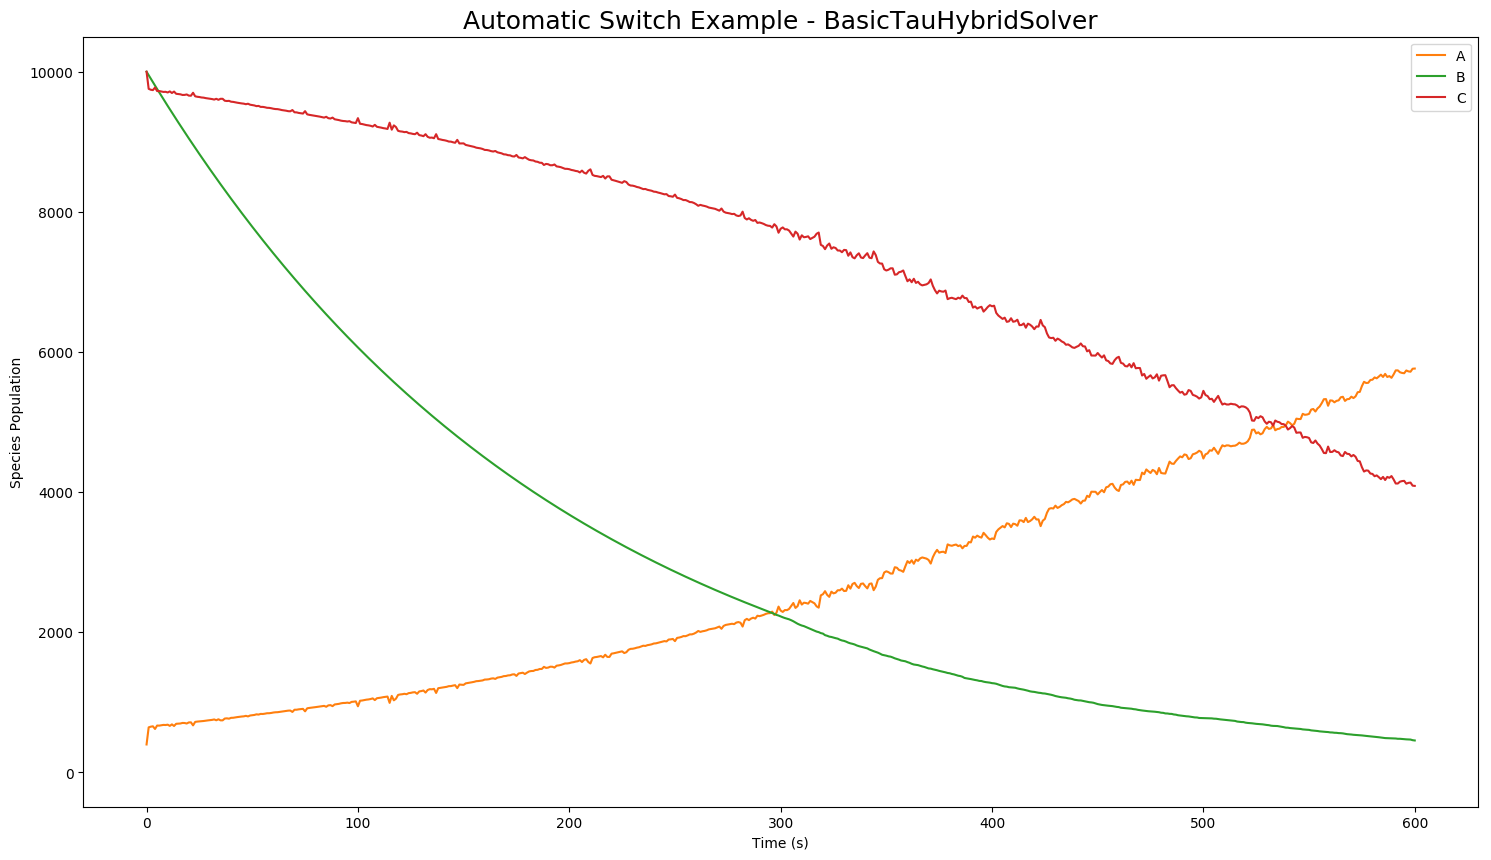

In [6]:
tau_hybrid_results.plot()

The hybrid switching condition is based on a coefficient of variance for each species.  The error threshhold for this condition can be user modified by instantiating the solver, and calling the run function from it, rather than the solver.  
  
The default value is .03 and is a threshold to the coefficient of variance for each species at the selected forward step (t + tau).  

Additionally, both the hybrid_tol and tau_tol can be modified to result in extremely fast simulations.

In [7]:
%time results2 = model.run(solver=BasicTauHybridSolver, switch_tol=.06, tau_tol=0.04)

CPU times: user 9.84 s, sys: 969 ms, total: 10.8 s
Wall time: 9.71 s


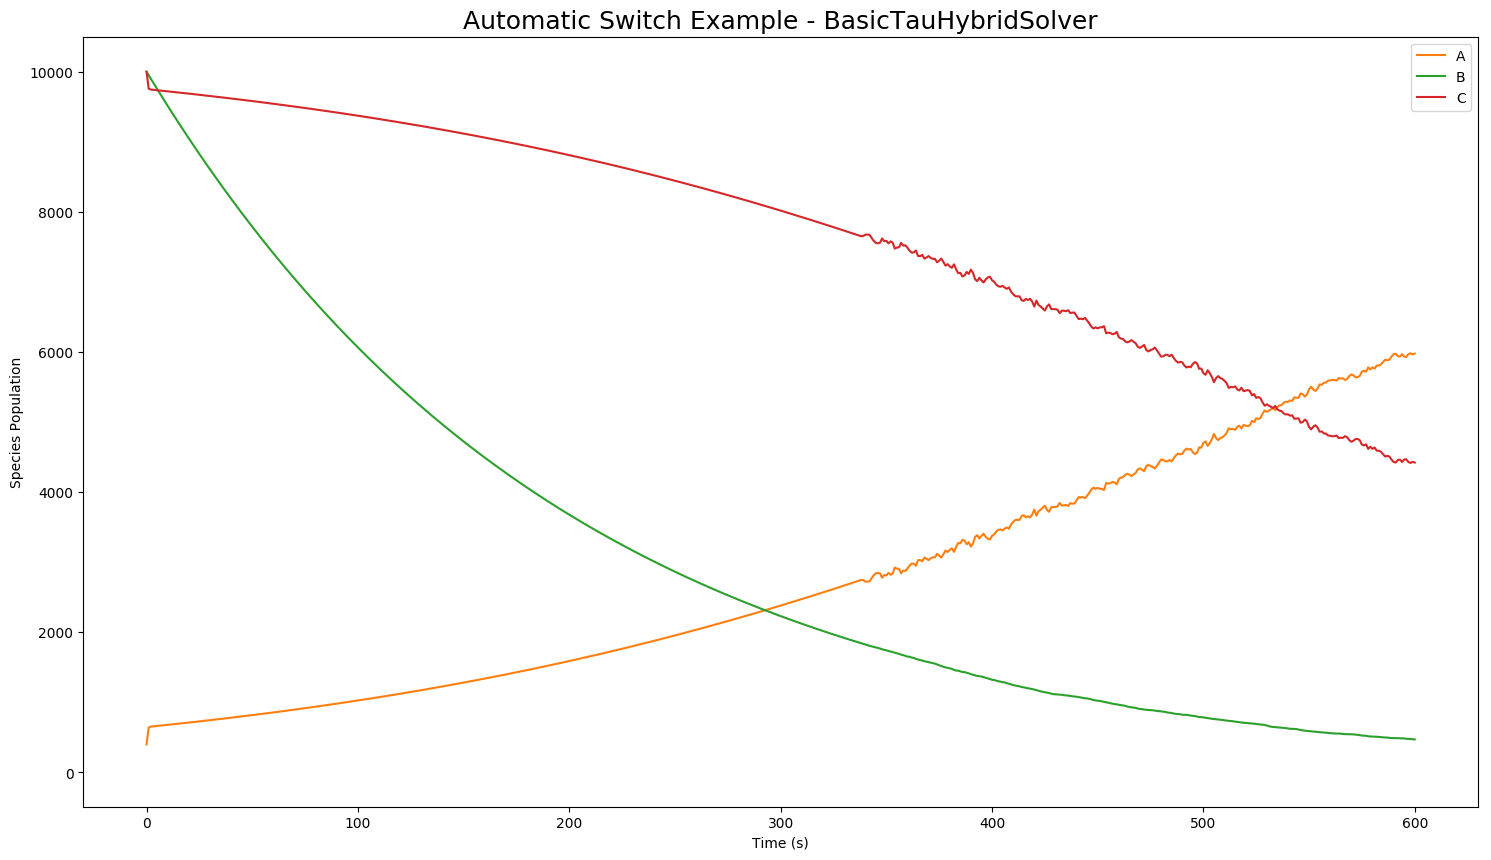

In [8]:
results2.plot()

../../../gillespy2/core/results.py:92: UserWarning: Results is of type dictionary. Use results['species'] instead of results[0]['species'] 
  warnings.warn("Results is of type dictionary. Use results['species'] instead of results[0]['species'] ")


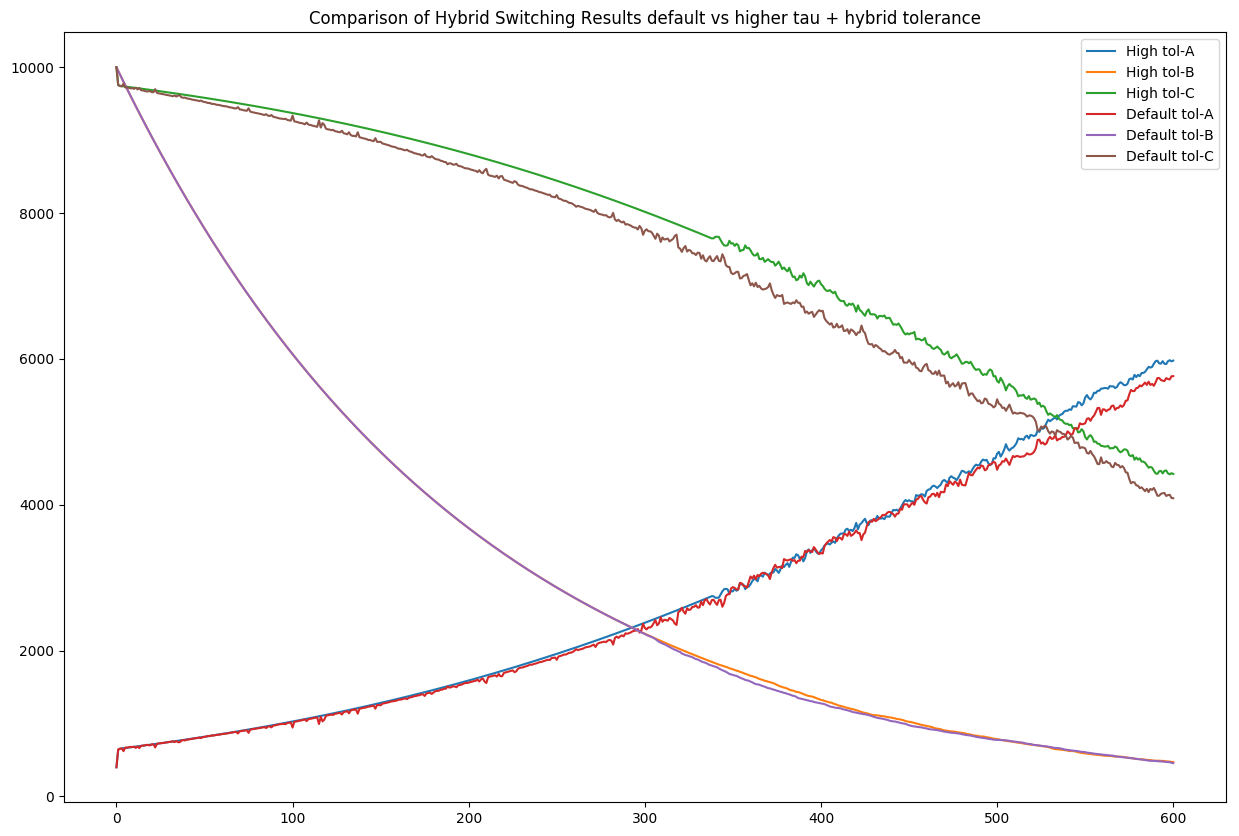

In [9]:
plt.figure(figsize=(15, 10))
plt.title('Comparison of Hybrid Switching Results default vs higher tau + hybrid tolerance')
for species in results2[0]:
    if species == 'time': continue
    plt.plot(results2[0]['time'], results2[0][species], label='High tol-{0}'.format(species))
for species in tau_hybrid_results[0]:
    if species == 'time': continue
    plt.plot(tau_hybrid_results[0]['time'], tau_hybrid_results[0][species], label='Default tol-{0}'.format(species))
    plt.legend(loc='best')

In [10]:
%time results3 = model.run()

CPU times: user 31.2 ms, sys: 297 ms, total: 328 ms
Wall time: 10.7 s


../../../gillespy2/core/results.py:92: UserWarning: Results is of type dictionary. Use results['species'] instead of results[0]['species'] 
  warnings.warn("Results is of type dictionary. Use results['species'] instead of results[0]['species'] ")


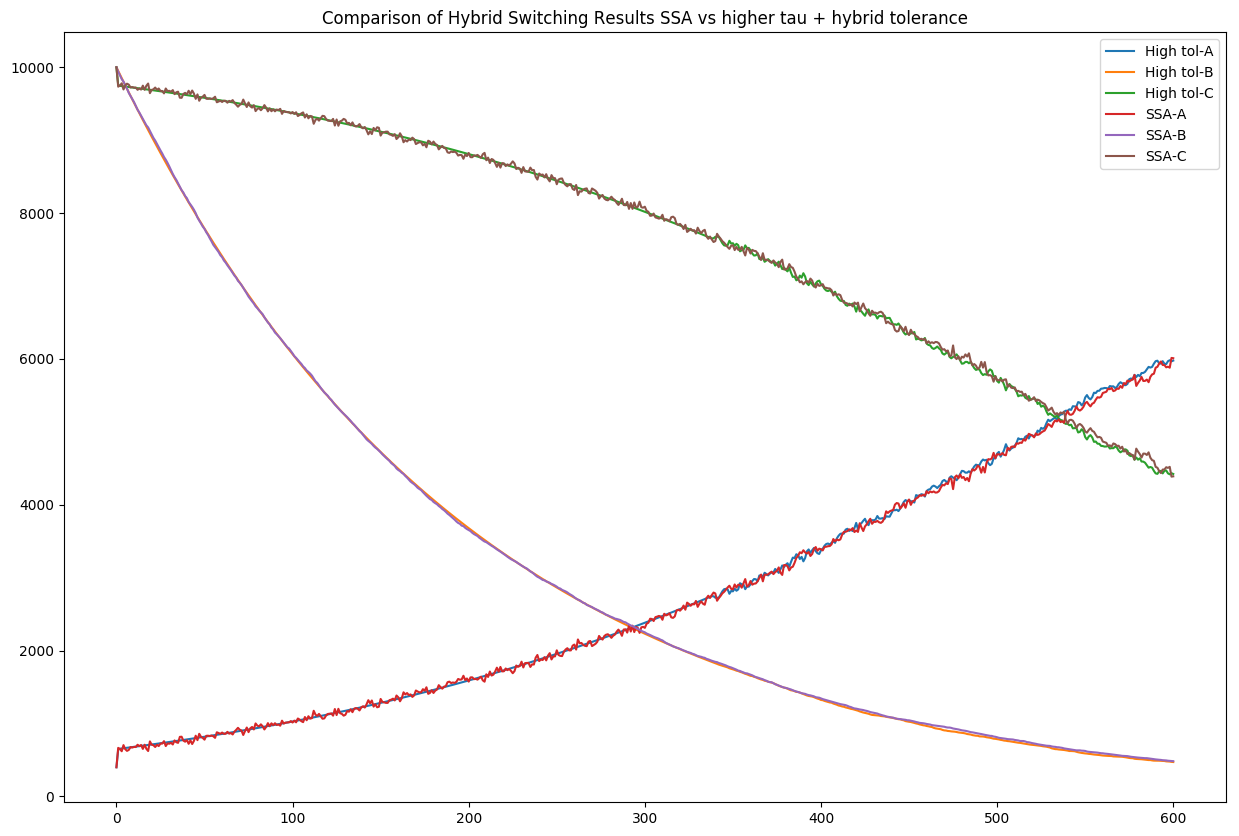

In [11]:
plt.figure(figsize=(15, 10))
plt.title('Comparison of Hybrid Switching Results SSA vs higher tau + hybrid tolerance')
for species in results2[0]:
    if species == 'time': continue
    plt.plot(results2[0]['time'], results2[0][species], label='High tol-{0}'.format(species))
for species in results3[0]:
    if species == 'time': continue
    plt.plot(results3[0]['time'], results3[0][species], label='SSA-{0}'.format(species))
    plt.legend(loc='best')